# Import dependiencies

In [43]:
from __future__ import annotations

import os
import ast
import numpy as np
import pandas as pd
import re
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from scipy.stats import gaussian_kde
from functools import wraps
from itertools import chain
from typing import Callable, List, Union
import seaborn as sns
import matplotlib.pyplot as plt

# Define global variables and constants

In [44]:
DATABASE_PATH = r'..\resources\database'
MODELS_PATH =  r'..\models'
COLUMNS = ['Text', 'Label']
SAVE_MODEL = True

# Load the dataset

In [46]:
COLUMNS = [
    'X-Virus-Scanned', 
    'X-Priority', 
    'Spam Score',
    'Encoding',
    'Attachments',
    'URL Links', 
    'URLs',
    'IPs', 
    'Images', 
    'Is HTML', 
    'Is JavaScript',
    'Is CSS',
    'Extracted Text',
    'Is Phishy'
]

COL_DTYPES = {
    'Encoding': str,
    'Extracted Text': str
}

In [47]:
emails_df = pd.read_csv(os.path.join(DATABASE_PATH, r'emails-database.csv'))

In [48]:
emails_df.dropna(how='any', subset=['Is Phishy'], inplace=True)

# Preprocess feature matrix

In [49]:
X = emails_df.drop(columns=['Is Phishy'], inplace=False)
y = emails_df['Is Phishy'].astype(int)

In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8837 entries, 0 to 8836
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Message-ID       8837 non-null   object 
 1   Date             8837 non-null   object 
 2   From             8837 non-null   object 
 3   To               8618 non-null   object 
 4   Subject          8705 non-null   object 
 5   Content-Length   1420 non-null   float64
 6   X-Virus-Scanned  208 non-null    object 
 7   X-Priority       3482 non-null   object 
 8   Spam Score       166 non-null    float64
 9   Attached Files   8837 non-null   object 
 10  Attachments      8837 non-null   int64  
 11  URL Links        8837 non-null   object 
 12  URLs             8837 non-null   int64  
 13  IP Addresses     8837 non-null   object 
 14  IPs              8837 non-null   int64  
 15  Images Embedded  8837 non-null   object 
 16  Images           8837 non-null   int64  
 17  Encoding      

In [59]:
def transformer_wrapper(func: Callable) -> FunctionTransformer:
    """
    Wrapper for multiple FunctionTransformer object instantiation.

    Parameters
    ----------
    func : Callable
        Callable function used for the transformation. 
    
    Returns
    -------
    transformer : sklearn.preprocessing.FunctionTransformer
        Function transformer object.
    
    Usage
    -----
    Wrapper takes the advantage of functions being applied on scalar values. A wrapped function is then applied to the pandas DataFrame.
    Add the @transformer_wrapper decorator above the function definition to use as a step in sklearn.pipe.Pipeline or transformer in sklearn.compose.ColumnTransformer. 

    Let's say that we want to round up the 'Population' column to the nearest integer. 
    We define a @transformer_wrapper decorated function rounding up a floating number, returning result explicitly casted to integer type. 
    Then this function can be used as a function transformer directly.

        @transformer_wrapper
        def round_up(val: float) -> int:
            return int(np.ceil(val)) 
        
        ctf = sklearn.compose.ColumnTransformer(transformers=[
            ...
            ('round', round_up, ['Population']),
            ...
        ])
    """
    @wraps(func)
    def wrapper(df: pd.DataFrame, *args, **kwargs) -> pd.DataFrame:
        """
        Inner wrapper function using the @functools.wraps decorator to preserve the signature/information of the function passed.
        Extends an existing function, without any modification to the original function source code.
        
        Parameters
        ----------
        df : pd.DataFrame
            Input pandas DataFrame.
        
        args : Any
            Additional arguments.
        
        kwargs : Any
            Additional keyword arguments.
        
        Returns
        -------
        df_t : pd.DataFrame
            Result of applying a function to the input DataFrame.
        """
        return df.applymap(func, *args, **kwargs)
    return FunctionTransformer(wrapper)

In [60]:
@transformer_wrapper
def enumerate_virus_scanned(virus_scanned: str) -> int:
    """
    Function to enumerate the X-Virus-Scanned rows.

    Parameters
    ----------
    virus_scanned : str
        X-Virus-Scanned value.
    
    Returns
    -------
    enum : int
        0 if X-Virus-Scanned is null, else 1.    
    """
    try:
        return int(len(virus_scanned) > 0)
    except TypeError:
        return 0

In [82]:
@transformer_wrapper
def impute_spam_score(spam_score: float) -> float:
    """
    Function to impute Spam Score rows.

    Parameters
    ----------
    spam_score : float
        Spam Score value.
    
    Returns
    -------
    _score : float
        Imputed Spam Score value.
    """
    return spam_score if not pd.isnull(spam_score) else 0.

In [62]:
@transformer_wrapper
def enumerate_priority(priority: str) -> int:
    """
    Function to enumerate X-Priority rows.
    Values: 1 (Highest), 2 (High), 3 (Normal), 4 (Low), 5 (Lowest). 3 (Normal) is default if the field is omitted. 0 is set if empty.

    Parameters
    ----------
    priority : str
        X-Priority value.
    
    Returns
    -------
    enum : int
        Enumerated X-Priority value.
    """
    try:
        return int(re.search(r'\d+', priority).group(0))
    except (AttributeError, TypeError):
        return 0

In [63]:
@transformer_wrapper
def enumerate_encoding(encoding: str) -> int:
    """
    Function to enumerate Encoding rows.

    Parameters
    ----------
    encoding : str
        Encoding value.
    
    Returns
    -------
    enum : int
        Enumerated Encoding value.
    """
    content_transfer_encoding = {
        "na":  0,
        "base64": 1,
        "quoted-printable": 2,
        "8bit": 3,
        "7bit": 4,
        "binary": 5
    }
    try:
        return content_transfer_encoding[encoding.lower()]
    except (AttributeError, KeyError):
        return 0

In [64]:
@transformer_wrapper
def enumerate_bool(boolean: bool) -> int:
    """
    Function to enumerate any boolean rows.

    Parameters
    ----------
    boolean : bool
        Boolean value.
    
    Returns
    -------
    enum : int
        Enumerated boolean value.
    """
    return int(boolean)

In [65]:
def get_message_length(text: str) -> int:
    """
    Function calculating length of a text message.

    Parameters
    ----------
    text : str
        Input text.
    
    Returns
    -------
    length : int
        Text length.
    """
    return len(str(text))

In [66]:
def get_url_characteristics(url_links: pd.Series) -> List[float]:
    """
    Extract intrinsic characteristics from list of URLs.

    Parameters
    ----------
    url_links : pd.Series
        Series containing a list or list-like string of URLs.

    Returns
    -------
    attribs : List[float]
        List of floating point numbers defining the security ratio, unicode ratio, average length and average number of levels in URLs embedded in an email message. 
    """
    def is_unicode(s: str):
        try:
            s.encode('ascii', 'strict')
            return True
        except UnicodeError:
            return False

    if isinstance(url_links[0], str):
        url_list = ast.literal_eval(url_links[0])
    else:
        url_list = url_links[0]
        
    secure_ratio, unicode_ratio, avg_length, avg_n_levels = 1., 1., .0, .0
    if url_list:
        secure_ratio = sum([int(s.lower().startswith('https')) for s in url_list]) / len(url_list)
        unicode_ratio = sum([int(is_unicode(s)) for s in url_list]) / len(url_list)
        avg_length = np.mean([len(s) for s in url_list])
        avg_n_levels = np.mean([len(s[s.find('://') + 3:].split('/')) for s in url_list])
    return [secure_ratio, unicode_ratio, avg_length, avg_n_levels]

In [67]:
class AttributeAdder(BaseEstimator, TransformerMixin): 
    """
    Custom Transformer class that applies a function on the input columns passed to the transformer and adds transformed data as new features to the output matrix.

    Attributes
    ----------
    attribs_in : List[str]
        List of processed input features.
    attribs_out : List[str]
        List of features added to the output matrix.
    func : Callable
        Function applied to transform input features.

    Methods
    -------
    fit(X, y=None)
        Fit the transformer using X (placeholder).

    transform(self, X)
        Transform X by applying a function to the specified columns and concatenate resulting axes as new columns.
    
    Usage
    -----
    Transformation step in the pipeline.
    
    Example
    -------
    Let's assume the input feature matrix consists of two columns: ['Net Salary', 'Gross Salary']
    We want to calculate mean salaries and add these values as new attributes: ['Avg Net Salary', 'Avg Gross Salary']
    The pipeline should be initialized as:
        
    sklearn.pipe.Pipeline(steps=[
        ...,
        ('avg_salaries', AttributeAdder(attribs_in=['Avg Net Salary', 'Avg Gross Salary'], attribs_out=['Net Salary', 'Gross Salary'], func=np.mean)),
        ...
    ])
    """

    def __init__(self, attribs_in: List[str], attribs_out: List[str], func: Callable) -> None:
        """
        Constructs all the necessary attributes for the custom transformer object.

        Parameters
        ----------
        attribs_in : List[str]
            List of processed input features.
        attribs_out : List[str]
            List of features added to the output matrix.
        func : Callable
            Function applied to transform input features.
        """

        super(AttributeAdder, self).__init__()
        self.attribs_in = attribs_in
        self.attribs_out = attribs_out
        self.func = func
    
    def fit(self, X: pd.DataFrame , y=None) -> AttributeAdder:
        """
        Fit the transformer using X (placeholder).

        Parameters
        ----------
        X : pd.DataFrame of shape (n_samples, n_features)
            Input data, of which specified subsets are used to fit the transformers.
        y : None, optional
            Ignored.
        
        Returns
        -------
        self : AttributeAdder
            This transformer.
        """
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Transform X by applying a function to the specified columns and concatenate resulting axes as new columns.

        Parameters
        ----------
        X : pd.DataFrame of shape (n_samples, n_features)
            Input data, of which specified subsets are used to fit the transformers.
        
        Returns
        -------
        X_t : pd.DataFrame
            Horizontally stacked results of the transformation.

        Raises
        ------
        KeyError
            If any of the input labels (attribs_in) is not found in the columns.
        """
        X_ = X[self.attribs_in].apply(self.func, axis=1, result_type="expand")
        return pd.DataFrame(
            data=np.c_[X, X_],
            columns=[*X.columns, *self.attribs_out]
        )

In [68]:
class AttributeDropout(BaseEstimator, TransformerMixin): 
    """
    Custom Transformer that removes selected attributes from the feature matrix.

    Attributes
    ----------
    exclude : List[str]
        List of features to remove.

    Methods
    -------
    fit(X, y=None)
        Fit the transformer using X (placeholder).

    transform(self, X)
        Remove selected attributes from the feature matrix.
    
    Usage
    -----
    Transformation step in the pipeline.
    
    Example
    -------
    Let's assume we want to exclude columns ['X-Priority', 'Attachments'] from the output.
    The pipeline should be initialized as:
        
    sklearn.pipe.Pipeline(steps=[
        ...,
        ('drop_out', AttributeDropout(exclude=['X-Priority', 'Attachments'])),
        ...
    ])
    """ 

    def __init__(self, exclude: List[str]) -> None:
        """
        Constructs all the necessary attributes for the custom transformer object.

        Parameters
        ----------
        exclude : List[str]
            List of features to remove.
        """
        super(AttributeDropout, self).__init__()
        self.exclude = exclude
    
    def fit(self, X: pd.DataFrame , y=None) -> AttributeDropout:
        """
        Fit the transformer using X (placeholder).

        Parameters
        ----------
        X : pd.DataFrame of shape (n_samples, n_features)
            Input data, of which specified subsets are used to fit the transformers.
        y : None, optional
            Ignored.
        
        Returns
        -------
        self : AttributeDropout
            This transformer.
        """
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Remove selected attributes from the feature matrix.

        Parameters
        ----------
        X : pd.DataFrame of shape (n_samples, n_features)
            Input data to be transformed.
        
        Returns
        -------
        X_t : pd.DataFrame
            DataFrame without the removed attributes.
        
        Raises
        ------
        KeyError
            If any of the labels is not found in the columns.
        """
        return X.drop(columns=self.exclude)

In [69]:
class NamedTransformer(ColumnTransformer):  
    """
    ColumnTransformer subclass, additionally supporting a keyed-access to heterogenous, multi-dimensional transformed data.
    
    Attributes
    ----------
    features_in : List[str]
        List of input features.

    Methods
    -------
    to_frame(data)
        Convert array-like input into a pandas DataFrame.

    fit(X, y=None)
        Fit the transformer using X (placeholder).

    transform(self, X)
        Transform X by converting array-like input into a pandas DataFrame.
    
    fit_transform(self, X, y)
        Fit and transform the data.
    
    Usage
    -----
    Use as a step in a sklearn.pipe.Pipeline to propagate forward a preprocessed tabular pd.DataFrame structure instead of a sparse-matrix.
    Output having labeled axes is beneficial if access to specific columns is necessary in subsequent transformers as data is propagated forward through a pipeline. 
    Manipulating with sparse matrices negatively impacts the computational time and memory usage as opposed to array-like objects. 
    """
    @property
    def features_in(self) -> List[str]:
        """
        List of columns from added transformers.

        Returns
        -------
        features_in : List[str]
            Concatenated list of input features used in each transformer.
        """
        return list(chain(*[cols for _,_,cols in self.transformers]))
    
    def to_frame(self, data: np.ndarray) -> pd.DataFrame:
        """
        Convert array-like input into a pandas DataFrame.

        Parameters
        ----------
        data : np.ndarray
            Array-like input.

        Returns
        -------
        df : pd.DataFrame
            Coverted pandas DataFrame.
        """
        return pd.DataFrame(data, columns=self.features_in).convert_dtypes()
    
    def fit(self, X: np.ndarray, y = None) -> NamedTransformer:
        """
        Fit the transformer using X.
        ColumnTransformer-derived objects ignore the y parameter.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data, of which specified subsets are used to fit the transformers.
        y : None, optional
            Ignored.
        
        Returns
        -------
        self : NamedTransformer
            This column transformer.
        """
        return super().fit(X, y)

    def transform(self, X: np.ndarray) -> pd.DataFrame:
        """
        Transform X by converting array-like input into a pandas DataFrame.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data to be transformed.
        
        Returns
        -------
        X_t : pd.DataFrame
            Converted pandas DataFrame.
        """
        return self.to_frame(super().transform(X))

    def fit_transform(self, X: np.ndarray, y = None) -> pd.DataFrame:
        """
        Fit and transform the transformer using X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Input data to be transformed.
        y : None, optional
            Ignored.
        
        Returns
        -------
        X_t : pd.DataFrame
            Converted pandas DataFrame.
        """
        return self.to_frame(super().fit_transform(X))

In [83]:
def features_pipeline(exclude: List[str] = [], normalize: bool = True, features_out: bool = False) -> Union[Pipeline, List[str]]:
    """
    Pipeline for features preprocessing (KNN inputs).
    
    Parameters
    ----------
    exclude : List[str], optional
        List of features to exclude. Default is an empty list.
    normalize : bool, optional
        If true (default), output valeus are normalized.
    features_out : bool, optional
        If true, output columns are returned. Default is False.

    Returns
    -------
    pipe : sklearn.pipeline.Pipeline
        Pipeline of transforms with a final estimator.
    features : List[str], optional
        List of output features. Only returned if features_out is True.
    """
    # Add new attributes based on the existing ones
    attrib_adder = make_pipeline(
        AttributeAdder(attribs_in=['Extracted Text'], attribs_out=['Message Length'], func=get_message_length),
        AttributeAdder(attribs_in=['URL Links'], attribs_out=['URL Secured Ratio', 'URL Unicode Ratio', 'URL Avg Length', 'URL Avg Levels'], func=get_url_characteristics)
    )
    
    # Transform selected columns
    preprocessor = NamedTransformer(transformers=[
        ('virus_scanned', enumerate_virus_scanned, ['X-Virus-Scanned']),
        ('priority', enumerate_priority, ['X-Priority']),
        ('spam_score', impute_spam_score, ['Spam Score']),
        ('encoding', enumerate_encoding, ['Encoding']),
        ('flags', enumerate_bool, ['Is HTML', 'Is JavaScript', 'Is CSS']),
        ('select', 'passthrough', ['Attachments', 'URLs', 'IPs', 'Images', 'Message Length', 'URL Secured Ratio', 'URL Unicode Ratio', 'URL Avg Length', 'URL Avg Levels'])
    ])

    # Drop selected columns
    attrib_dropout = AttributeDropout(exclude)

    # Define pipeline
    pipe = Pipeline(steps=[
        ('attrib_adder', attrib_adder),
        ('preprocessor', preprocessor),
        ('attrib_dropout', attrib_dropout),
        ('scaler', StandardScaler() if normalize else None)
    ])

    # Get features out
    if features_out:
        features = [col for col in preprocessor.features_in if col not in exclude]
        
        # Return pipeline and features
        return pipe, features
    
    # Return pipeline
    return pipe

# Visualize predictors

In [71]:
# Transform features without scaling
pipe_no_scaling, features = features_pipeline(normalize=False, features_out=True)

# Convert data to a DataFrame
X_no_scaling = pd.DataFrame.from_records(
    data=pipe_no_scaling.fit_transform(X),
    columns=features,
)

# Prepare data for visualization
data_viz = pd.concat([X_no_scaling, y], axis=1).astype(float)

## Distribution analysis

In [20]:
def percentage(arr: np.ndarray) -> np.ndarray:
    return (arr / arr.max()) * 100

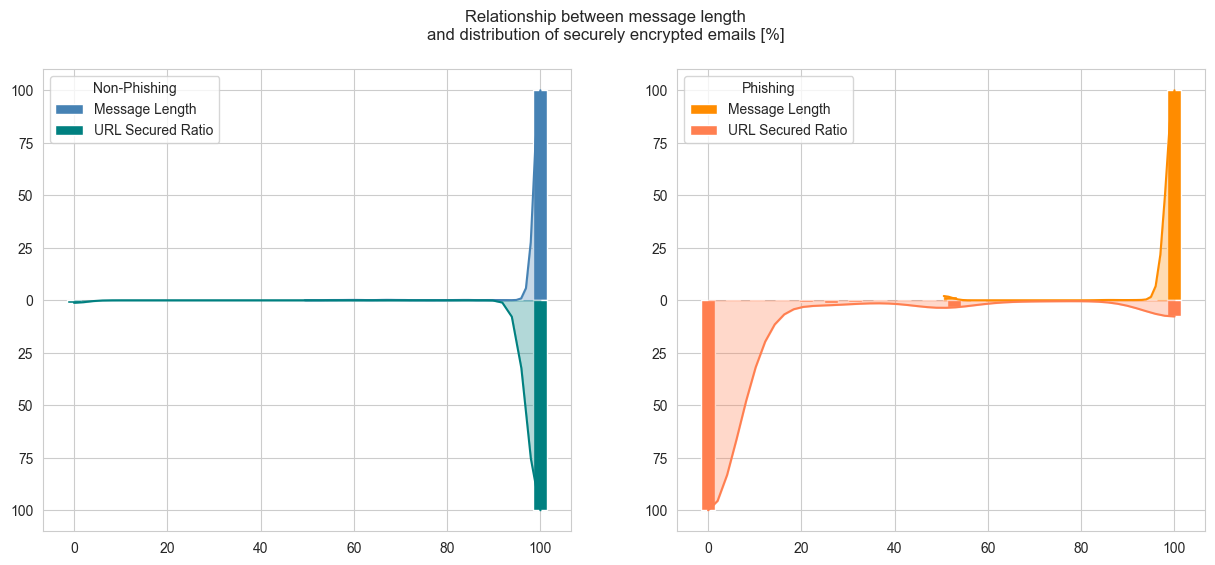

In [21]:
sns.set_style("whitegrid")
columns = ['Message Length', 'URL Secured Ratio']
plot_params = [
    (0, 'Non-', ['steelblue', 'teal']),
    (1, '', ['darkorange','coral']),
]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
for i, label, color in plot_params:
    for j, column in zip([1, -1], columns):
        c = color[not j > 0]
        yy = data_viz.loc[data_viz['Is Phishy'] == i, column]
        
        # Histogram
        heights, bin_edges = np.histogram(yy, density=True, bins=20) 
        ax[i].bar(percentage(bin_edges[:-1]), percentage(heights) * j, width=3, color=c, label=column)
        
        # KDE
        kde = gaussian_kde(yy, bw_method=0.25)
        xx = np.linspace(yy.min(), yy.max(),) # len(yy))
        kde_eval = kde.evaluate(xx)
        ax[i].plot(percentage(xx), percentage(kde_eval) * j, color=c)
        ax[i].fill_between(percentage(xx), percentage(kde_eval) * j, color=c, alpha=0.3)

    y_ticks = ax[i].get_yticks()[1:-1]
    ax[i].set_yticks(y_ticks) # Surpress FixedFormatter warning
    ax[i].set_yticklabels(np.abs(y_ticks).astype(int))
    ax[i].legend(title=f'{label}Phishing')
plt.suptitle('Relationship between message length\nand distribution of securely encrypted emails [%]')
plt.show()


## Ratio of HTTPS encrypted URLs

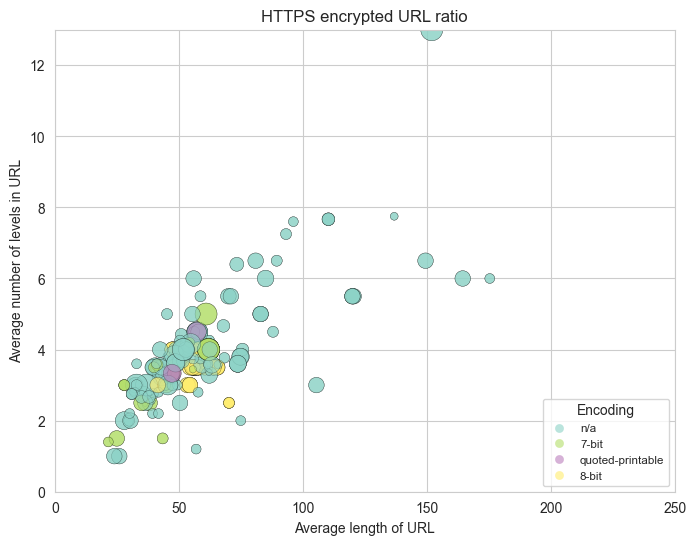

In [22]:
# Set the figure size
plt.figure(figsize=(8, 6))

# Data to visualize
_data = data_viz[data_viz['URL Avg Length'] > 0]

# Color labels
encoding_labels = {
    0: "n/a",
    1: "base-64",
    2: "quoted-printable",
    3: "8-bit",
    4: "7-bit",
    5: "binary"
}

# Scatterplot
sc = plt.scatter(
    x=_data['URL Avg Length'], 
    y=_data['URL Avg Levels'], 
    s=_data['URL Secured Ratio'] * 250, 
    c=_data['Encoding'], 
    cmap="Set3", 
    alpha=0.6, 
    edgecolors="black", 
    linewidth=0.25)
 
# Add plot descriptors
plt.xlabel("Average length of URL")
plt.ylabel("Average number of levels in URL")
plt.title("HTTPS encrypted URL ratio")
plt.xlim(0, 250)
plt.ylim(0, 13)
plt.legend(
    handles=sc.legend_elements("colors")[0], 
    labels=[encoding_labels[i] for i in _data['Encoding'].unique()], 
    title='Encoding', 
    fontsize='small', 
    fancybox=True, 
    loc='lower right'
)
plt.show()

# Relationship between URL length and number of levels contained

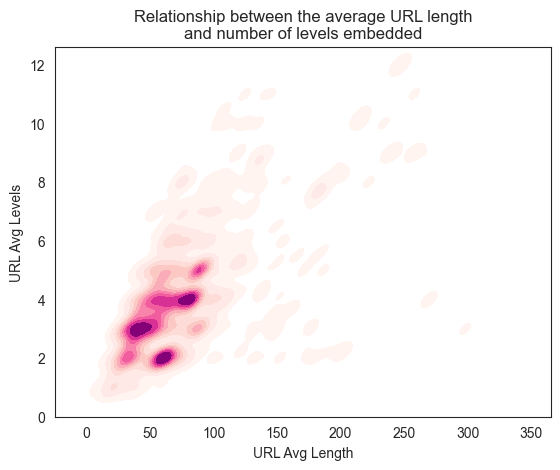

In [23]:
# set seaborn style
sns.set_style("white")

_data = data_viz[data_viz['URL Avg Length'] > 0]
 
# Custom the color, add shade and bandwidth
sns.kdeplot(x=_data['URL Avg Length'], y=_data['URL Avg Levels'], cmap="RdPu", fill=True, bw_adjust=.5)
plt.xlim(-25, _data['URL Avg Length'].max() * 0.9)
plt.ylim(0, _data['URL Avg Levels'].max() * 0.9)
plt.title("Relationship between the average URL length\nand number of levels embedded")
plt.show()

## Presence of attachments, links and images

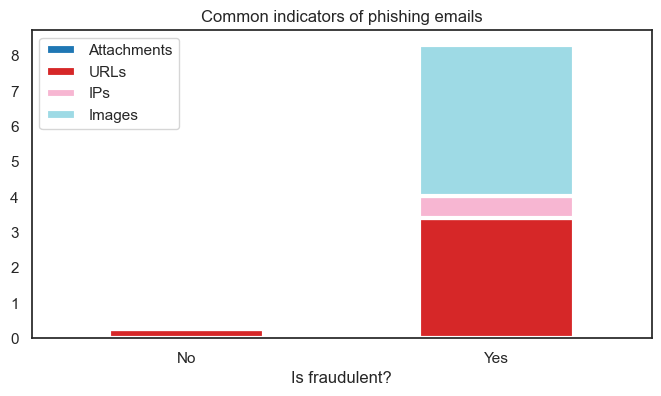

In [24]:
# Set plot style: grey grid in the background
sns.set(style="white")

# Set the figure size
fig, ax = plt.subplots(figsize=(8, 4))

# Aggregate features on target
_data = data_viz[['Attachments', 'URLs', 'IPs', 'Images', 'Is Phishy']].groupby('Is Phishy').mean()

# Plot grouped bars
_data.plot(kind='bar', stacked=True, width=0.5, cmap="tab20", edgecolor="white", linewidth=3, ax=ax)
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], rotation=0)
plt.legend(loc='upper left')
plt.title('Common indicators of phishing emails')
plt.xlabel('Is fraudulent?')
plt.show()

# Find the most correlated predictors

In [72]:
# Transform & normalize features
pipe = features_pipeline()

# Convert transformed data into a DataFrame
X_processed = pd.DataFrame.from_records(
    data=pipe.fit_transform(X),
    columns=features,
)

# Compute a correlation matrix
cm = pd.concat([X_processed, y], axis=1).corr().fillna(.0)

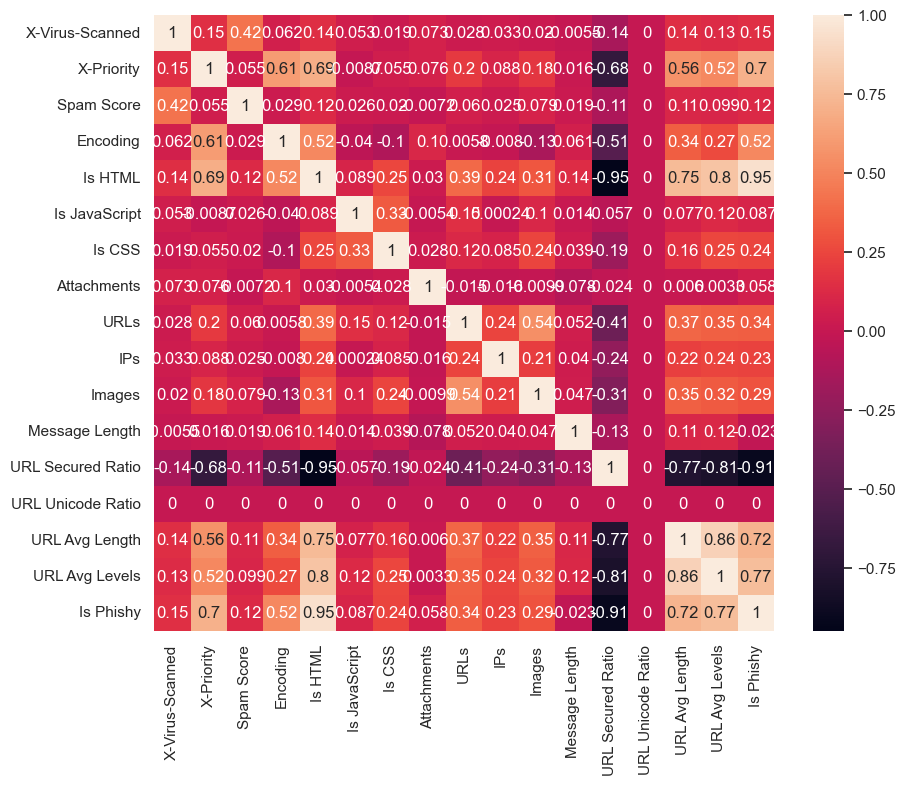

In [73]:
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True)
plt.show()

In [74]:
# List correlations in the descending order 
cm['Is Phishy'].sort_values(key=lambda x: x.abs(), ascending=False)[1:]

Is HTML              0.945252
URL Secured Ratio   -0.908034
URL Avg Levels       0.767078
URL Avg Length       0.718967
X-Priority           0.704852
Encoding             0.515557
URLs                 0.338730
Images               0.291558
Is CSS               0.240563
IPs                  0.232223
X-Virus-Scanned      0.150430
Spam Score           0.116342
Is JavaScript        0.086578
Attachments          0.058411
Message Length      -0.023204
URL Unicode Ratio    0.000000
Name: Is Phishy, dtype: float64

In [75]:
# Get features that are least correlated with the target
NON_CORRELATED_FEATURES = cm[cm['Is Phishy'].abs() < 0.2]['Is Phishy'].index.tolist()
NON_CORRELATED_FEATURES

['X-Virus-Scanned',
 'Spam Score',
 'Is JavaScript',
 'Attachments',
 'Message Length',
 'URL Unicode Ratio']

# Perform stratified shuffle split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=35)

In [77]:
pipe = features_pipeline(exclude=NON_CORRELATED_FEATURES)
X_train_norm = pipe.fit_transform(X_train)
X_test_norm = pipe.transform(X_test)

# Ensemble learning

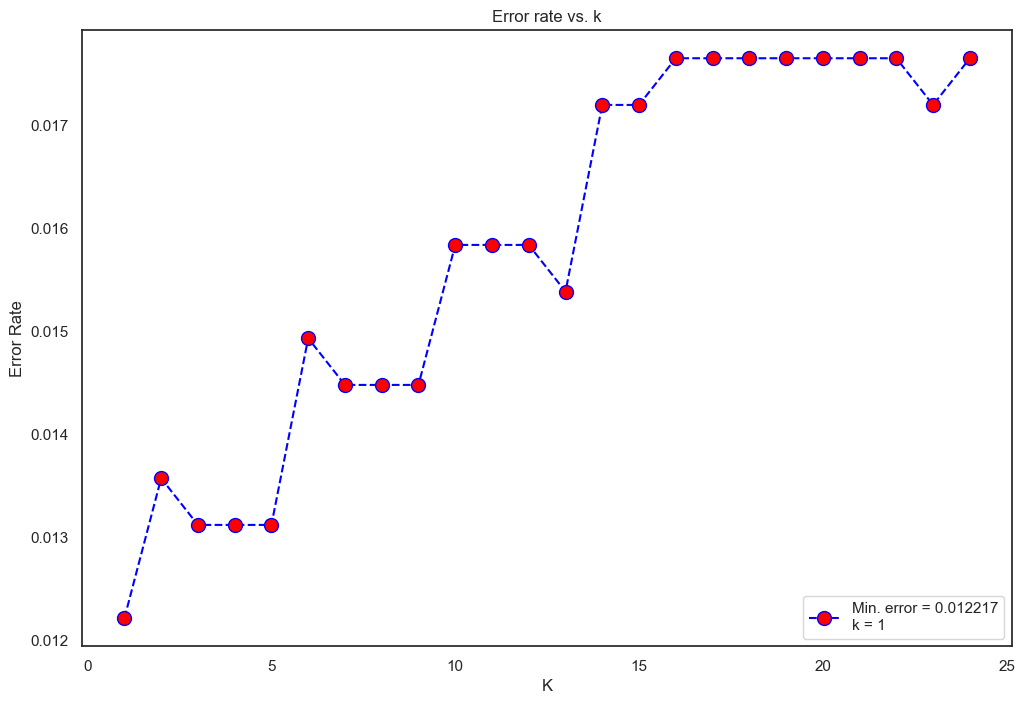

In [78]:
error_rates = pd.Series(dtype=np.float32)
for i in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_norm, y_train)
    y_pred = knn.predict(X_test_norm)
    error = np.mean(y_pred != y_test)
    error_rates.loc[i] = error

plt.figure(figsize=(12, 8))
plt.plot(
    error_rates, 
    color='blue', 
    linestyle='dashed', 
    marker='o',
    markerfacecolor='red', 
    markersize=10,
    label='Min. error = {:.6f}\nk = {}'.format(error_rates.min(), error_rates.idxmin())
)
plt.title('Error rate vs. k')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.legend(loc='lower right')
plt.show()

## Soft-voting

In [79]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

In [80]:
classifiers = [
    KNeighborsClassifier(weights='distance', n_neighbors=3),
    RandomForestClassifier(n_estimators=100, warm_start=True, bootstrap=False, random_state=17),
]

model_names = [
    'K-Nearest Neighbors', 
    'Random forest',
    'Ensemble'
]

eclf = VotingClassifier(
    estimators=list(zip(['knn', 'rfc'], classifiers)),
    voting='soft')

In [81]:
fitted_models = []
for name, clf in zip(model_names, [*classifiers, eclf]):
    cv_results = cross_validate(clf, X_train_norm, y_train, scoring='accuracy', cv=5, return_estimator=True)
    scores = cv_results['test_score']
    idx = np.argmax(scores)
    fitted_models.append((name, cv_results['estimator'][idx]))
    print("Validation accuracy: %0.4f (+/- %0.4f) [%s]" % (scores.mean(), scores.std(), name))

Validation accuracy: 0.9896 (+/- 0.0015) [K-Nearest Neighbors]
Validation accuracy: 0.9903 (+/- 0.0020) [Random forest]
Validation accuracy: 0.9903 (+/- 0.0020) [Ensemble]


In [40]:
for name, clf in fitted_models:
    score = clf.score(X_test_norm, y_test)
    print("Testing accuracy: %0.4f [%s]" % (score * 100, name))

Testing accuracy: 98.6878 [K-Nearest Neighbors]
Testing accuracy: 98.7330 [Random forest]
Testing accuracy: 98.7330 [Ensemble]


In [36]:
grid_params = {
    'rfc__n_estimators': [100, 250],
    'knn__n_neighbors': [1, 3, 5], 
}

gs = GridSearchCV(estimator=eclf, param_grid=grid_params, cv=5)
gs.fit(X_train_norm, y_train)

GridSearchCV(cv=5,
             estimator=VotingClassifier(estimators=[('knn',
                                                     KNeighborsClassifier(weights='distance')),
                                                    ('rfc',
                                                     RandomForestClassifier(bootstrap=False,
                                                                            random_state=17,
                                                                            warm_start=True))],
                                        voting='soft'),
             param_grid={'knn__n_neighbors': [1, 3, 5],
                         'rfc__n_estimators': [100, 250]})

In [37]:
print("Best score: {:.4f}".format(gs.best_score_))
print(f"Best params: {gs.best_params_}")

Best score: 0.9903
Best params: {'knn__n_neighbors': 3, 'rfc__n_estimators': 100}


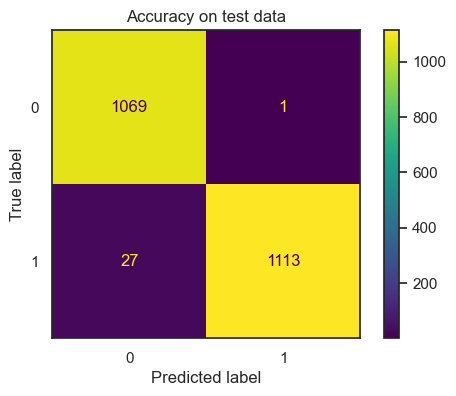

In [41]:
fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay.from_estimator(gs.best_estimator_, X_test_norm, y_test, ax=ax)
plt.title('Accuracy on test data')
plt.show()

# Export trained model

In [42]:
if SAVE_MODEL:
    out_path = os.path.join(MODELS_PATH, 'Ensemble', 'ensemble_classifier.joblib')
    joblib.dump(gs.best_estimator_, out_path)
    print(f'[!] Model saved as {os.path.abspath(out_path)}')

[!] Model saved as d:\PyCharm Professional\Projects\Integrated phishing detection for IMAP servers\models\Ensemble\ensemble_classifier.joblib
